In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import plotly.graph_objs as go

import tslearn
from tslearn.metrics import dtw as tslearn_dtw
import pandas as pd
import numpy as np

from typing import List
from typing import Union
from typing import Tuple


In [132]:
SHIFT_STEP = 3
NB_SAMPLES = SHIFT_STEP * 5
WINDOW_LENGTH = 30
DILATION_RATIO = 1.5

def get_well_relevant_windows(top_index: int, df_well: pd.DataFrame, nb_samples: int=NB_SAMPLES,
                              shift: int=SHIFT_STEP, ratio: Union[None, float]=None) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """
    Given df_well : 'wellName', 'DEPTH', 'GR' and top_index the position of a top in df_well
    Returns a list of numerous windows around top_index, and their label
    Labels are either True or False
    for a given selected window it is labelled True if the distance between its center and
    the top position is less than 4

    :param top_index: int
    :param df_well: pd.DataFrame(columns=['wellName', 'DEPTH', 'GR'])
    :param nb_samples: int
    :param shift: int=SHIFT_STEP
    :param ratio: Union[None, float]=None
    :return: list
    """
    windows = []
    labels = []
    positives = 0
    negatives = 0
    for i in range(top_index - nb_samples, top_index + nb_samples, shift):
        left_limit = i - WINDOW_LENGTH
        right_limit = i + WINDOW_LENGTH
        window_data = list(map(lambda x: np.array([x]), list(df_well['GR'].values[left_limit:right_limit + 1])))
        if np.array(window_data).shape != (WINDOW_LENGTH * 2 + 1, 1):
            continue
        label = abs(df_well['DEPTH'].iloc[i] - df_well['DEPTH'].iloc[top_index]) < 4
        if ratio:
            if label:
                windows.append(np.array(window_data))
                labels.append(np.array(label))
            elif negatives / max(positives + negatives, 1) < ratio:
                pass
            else:
                windows.append(np.array(window_data))
                labels.append(np.array(label))
        else:
            windows.append(np.array(window_data))
            labels.append(np.array(label))

        if label:
            positives += 1
        else:
            negatives += 1

    return windows, labels


# TODO: check index and len depth

def generate_top_dataset(df_logs: pd.DataFrame, df_tops: pd.DataFrame,
                         top: str='CONRAD', ratio: Union[None, float]=None):
    """
    From df_logs and df_tops for each well
    return a list of relevant windows from the whole signal of the well and the labels of the windows
    a relevant window depend on the top
    for more explanation about window selection cf get_well_relevant_windows

    df_logs contains : 'wellName', 'DEPTH', 'GR'
    df_tops contains a column top

    :param df_logs: pd.DataFrame
    :param df_tops: pd.DataFrame
    :param top: str='CONRAD'
    :param ratio: Union[None, float]=None
    :return:
    """
    windows = []
    labels = []
    for well_name in df_logs['wellName'].drop_duplicates().tolist():
        df_well = df_logs[df_logs['wellName'] == well_name]
        top_position = df_tops.loc[well_name][top]
        if np.isnan(top_position):
            print("NAN FOUND")
            continue
        depth_list = list(df_well['DEPTH'].values)
        real_top_position = min(df_well['DEPTH'].values,
                                key=lambda x: abs(x - top_position))  # SOMETIMES top_position not in df_logs
        if abs(real_top_position - top_position) > 3:
            print("DATA BAD LABELLED")
            continue
        top_index = depth_list.index(real_top_position)
        windows_, labels_ = get_well_relevant_windows(top_index=top_index, df_well=df_well, shift=1, nb_samples=1 * 100,
                                                      ratio=ratio)
        windows += windows_
        labels += labels_
    return windows, labels



class TopFinder:
    """
    TopFinder: wrapper for window classifier
    
    Limitations:
    - Work on single one top and assume independence among tops
    - Find top by classifying windows extracted from well data and discard
      the correlation between windows
    - Does not utilize geographical info of wells

    Usage example:

        >>> model.fit(dataset)
        >>> model.evaluate_windows = a_func

        >>> top_finder = TopFinder(model, top_name)
        >>> top_finder.examine_dataset(df_tops)

        >>> predicted_depth = top_finder.find_top(df_well)

    """

    def __init__(self, fitted_window_classifier, top_name):
        if fitted_window_classifier.evaluate_windows is None:
            raise ValueError("fitted_window_classifier has to have function evaluate_windows")
        self.window_classifier = fitted_window_classifier
        self.work_on_top = top_name
        self.stats = {}

    def examine_dataset(self, df_tops:pd.DataFrame):
        self.stats['top_depth_max'] = df_tops[self.work_on_top].max()
        self.stats['top_depth_min'] = df_tops[self.work_on_top].min()

    def extract_window(self, df_well:pd.DataFrame, center_idx, window_length):
        left_limit = center_idx - window_length
        right_limit = center_idx + window_length
        window = df_well.loc[left_limit : right_limit, 'GR'].to_numpy()
        return window

    def get_candidate_windows(self, df_well:pd.DataFrame):
        '''
        extra prior knowledge may be used to narrow down the scope of candidates, 
        e.g. top distribution. 

        return list of windows. Each window includes the depth of its center & GR data.
        '''
        max_, min_ = self.stats['top_depth_max'], self.stats['top_depth_min']
        center_  = (max_ + min_) / 2
        depth_diff_ = max_ - min_
        dilated_max_ =  center_ + DILATION_RATIO * depth_diff_ / 2
        dilated_min_ =  center_ - DILATION_RATIO * depth_diff_ / 2

        windows = []
        for idx, row in df_well.iterrows():
            if row['DEPTH'] < dilated_max_ and row['DEPTH'] > dilated_min_:
                window_depth = row['DEPTH']
                window_data = self.extract_window(df_well, idx, WINDOW_LENGTH)
                if window_data.shape != (WINDOW_LENGTH * 2 + 1,):
                    # print(window_data.shape) 
                    # It happens when the window gets out of the scope of well depth
                    continue
                windows.append((window_depth, window_data))
        return windows

    def select_window(self, windows, scores: np.array):
        '''
        extra prior knowledge may be used here, e.g. top relationships
        '''
        index_max = np.argmax(scores, axis=0)
        return windows[index_max]

    def find_top(self, df_well):
        """
        Step:
            1. Extract all candidate windows from the well
            2. Evalute each candidate by window classifier
            3. Select the best candidate
            4. Return its associated depth
        """
        if self.window_classifier is None:
            raise Exception("window_classifier is not set")
        if df_well.shape[0] == 0:
            raise Exception("input well has no data")

        self.windows = self.get_candidate_windows(df_well)
        print(f'{len(self.windows)} candidate windows')
        windows_data = np.array([w[1] for w in self.windows])
        self.scores = self.window_classifier.evaluate_windows(windows_data)
        selected_window = self.select_window(self.windows, self.scores)
        self.top_depth = selected_window[0]

        return self.top_depth



def get_true_windows(df_logs, df_tops, top_, keep_depth = False):
    dataset = generate_top_dataset(df_logs=df_logs, df_tops=df_tops, top=top_)
    all_well_names = df_logs['wellName'].unique()
    print(f'{len(dataset[0])} windows extracted from {len(all_well_names)} wells')

    X = np.array(dataset[0]).squeeze(axis=2)
    y = np.array(dataset[1])
    
    print('X:', X.shape)
    print('y:', y.shape)

    true_idx = [idx for idx in range(len(X)) if y[idx] == True]
    print(f'{len(true_idx)} true windows left')

    return X[true_idx]

def get_true_depth(wellname, top, df_tops):
    return df_tops.loc[wellname, top]


def visual_scores(depths, scores, max_score_depth=None, true_depth=None, well_name=None):
    data = []
    data.append(go.Scatter(x=depths,y=scores))
    title = "Evaluation Score w.r.t depth"
    if well_name:
        title += f' [well: {well_name}]'
    fig = go.Figure(data=data, layout={'title':title})
    if max_score_depth:
        fig.add_vline(x=max_score_depth, line_width=2, line_color="yellow", \
            annotation_text='Predicated', annotation_position='top left')
    if true_depth:
        fig.add_vline(x=true_depth, line_width=2, line_color="green", \
            annotation_text='True', annotation_position='top right')
    return fig
def instance_norm(sample: np.array):
    s = (sample - np.min(sample)) / (np.max(sample) - np.min(sample) + 1)
    return s


Retrieve markers in wells for specified top

In [133]:
tops = ['SYLVAIN', 'MARCEL', 'CONRAD']
top_ = 'CONRAD'
df_logs_ = pd.read_parquet("../data/logs.parquet")
df_loc_ = pd.read_parquet("../data/loc.parquet")
df_tops_ = pd.read_parquet("../data/tops.parquet")


# df_logs_ = pd.read_parquet("../testdata/logs_50.parquet")
# df_loc_ = pd.read_parquet("../testdata/loc_50.parquet")
# df_tops_ = pd.read_csv("../testdata/tops_50.csv", index_col=0)

In [134]:

def get_well_marker(top_index: int, df_well: pd.DataFrame, window_len: int, shift: int):

    left_limit = top_index - window_len
    right_limit = top_index + window_len
    window_data = df_well['GR'].loc[left_limit:right_limit]
    window_data = np.array(window_data).reshape(-1)
    # print(top_index, df_well.shape, df_well.index[-1], len(window_data))
    return window_data

WIN_LEN = 60
SHIFT = 1

no_match_count = 0
well_marker = dict()
for well_name in df_tops_.index:
    true_depth = df_tops_.loc[well_name][top_]
    df_well = df_logs_[df_logs_['wellName'] == well_name]
    true_depth_row = df_well[df_well['DEPTH'] == true_depth]
    true_depth_idx = true_depth_row.index
    if true_depth_idx.shape[0] == 1:
        # print(well_name)
        marker = get_well_marker(true_depth_idx.values[0], df_well, WIN_LEN, SHIFT)
        well_marker[well_name] = marker
    else:
        no_match_count += 1
print(f'{no_match_count} wells don\'t match. Markers of {len(well_marker)} wells found. ') 

14 wells don't match. Markers of 586 wells found. 


Visualization

In [135]:
def random_sample_n(X, k):
    samples = random.sample(X, k=k)
    return samples

def avg_window(samples: np.ndarray, normalize:bool = False):
    '''
    normalize: normalize the data or not
    '''
    if normalize:
        normalized = [instance_norm(sample) for sample in samples]
        return np.average(normalized, 0)
    else:
        return np.average(samples, 0)


Window size = 121  GR measures


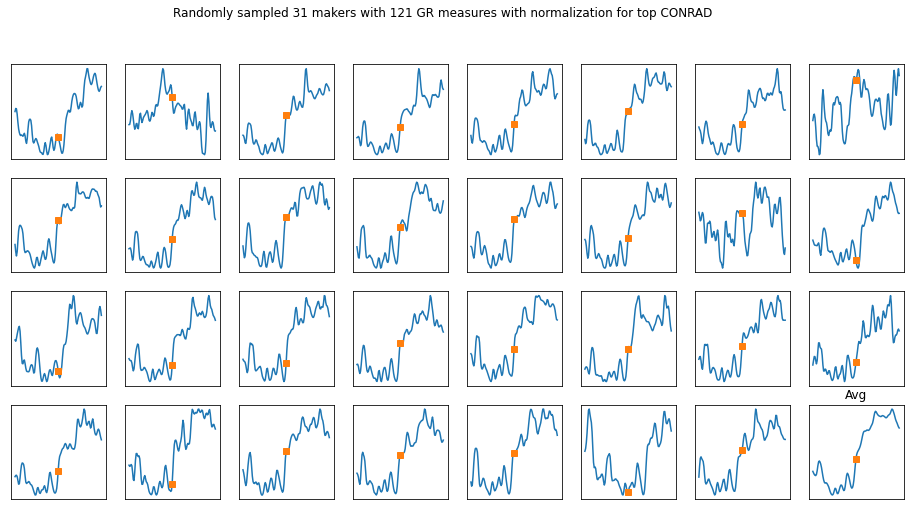

In [136]:
w, h = 4, 8
sample_num = w * h - 1
samples = random_sample_n(list(well_marker.values()), sample_num)
fig, axes = plt.subplots(w, h, figsize=(16,8))
fig.suptitle(f"Randomly sampled {sample_num} makers with {2*WIN_LEN+1} GR measures with normalization for top {top_}")
print("Window size =", 2*WIN_LEN+1, ' GR measures' )
for i, ax in enumerate(axes.flat[:-1]):
    data = samples[i]
    ax.plot(range(len(data)), data)
    ax.plot([WIN_LEN], [data[WIN_LEN]], 's')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # ax.set_title('Avg w. norm')

ax = axes.flat[-1]  
data = avg_window(samples[:-2], normalize=True)
ax.plot(range(len(data)), data)
ax.plot([WIN_LEN], [data[WIN_LEN]], 's')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Avg')

plt.show()

Correlation analysis

In [137]:
from dtaidistance import dtw
from scipy.spatial.distance import pdist

In [138]:
well_names = list(well_marker.keys())
dist_m_wo_norm = dtw.distance_matrix_fast(list(well_marker.values()))
dist_m_w_norm = dtw.distance_matrix_fast([instance_norm(marker) for marker in list(well_marker.values())])

In [139]:
len(well_names)

586

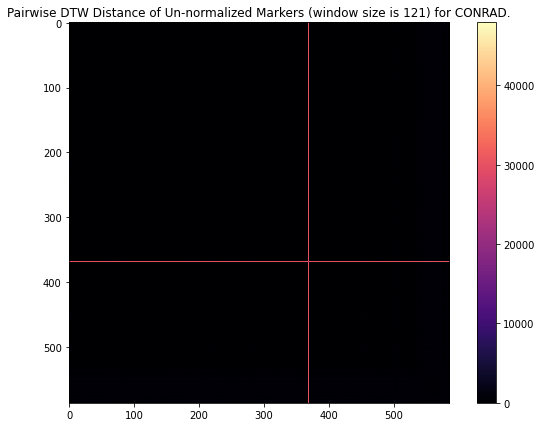

In [140]:
# Heat map
plt.figure(figsize = (10,7))
plt.imshow(dist_m_wo_norm , cmap = 'magma')

plt.title( f"Pairwise DTW Distance of Un-normalized Markers (window size is {2*WIN_LEN+1}) for {top_}." )
plt.colorbar()
plt.savefig(fname='dtw_distance_matrix/' + f'{top_}-{WIN_LEN}-{df_tops_.shape[0]}-unnormalized.png')
plt.show()

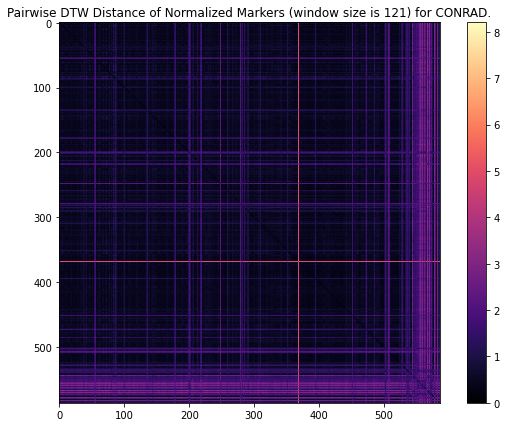

In [141]:
# Heat map
plt.figure(figsize = (10,7))
plt.imshow(dist_m_w_norm , cmap = 'magma')

# plt.title( f"Pairwise DTW Distance of Normalized Markers for {top_}" )
plt.title( f"Pairwise DTW Distance of Normalized Markers (window size is {2*WIN_LEN+1}) for {top_}." )
plt.colorbar()
plt.savefig(fname='dtw_distance_matrix/' + f'{top_}-{WIN_LEN}-{df_tops_.shape[0]}-normalized.png')
plt.show()
# plt.savefig(fname = f'dtw_distance_matrix/{top_}-{df_tops_.shape[0]}-normalized.png')

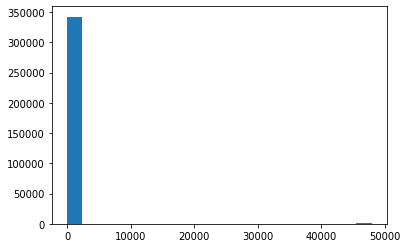

In [142]:
plt.hist(dist_m_wo_norm.flatten(), bins=20)
plt.show()

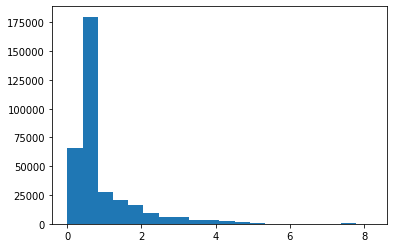

In [143]:
plt.hist(dist_m_w_norm.flatten(), bins=20)
plt.show()

In [144]:
len(dist_m_w_norm)

586

Next

In [145]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(metric='precomputed', min_samples=10, eps=0.5, algorithm="brute")
clustering.fit(dist_m_w_norm)


DBSCAN(algorithm='brute', metric='precomputed', min_samples=10)

In [146]:
len(clustering.labels_), set(clustering.labels_)

(586, {-1, 0})

In [147]:
labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d from %d data points" % (n_noise_, len(labels)))

# label_id -> [wellnames]
clustered_well_names = {label : [well_names[i] for i, l in enumerate(labels) if l == label] for label in set(labels)}
for label, wns in clustered_well_names.items():
    print(f"label {label}: {len(wns)} wells")

Estimated number of clusters: 1
Estimated number of noise points: 75 from 586 data points
label 0: 511 wells
label -1: 75 wells


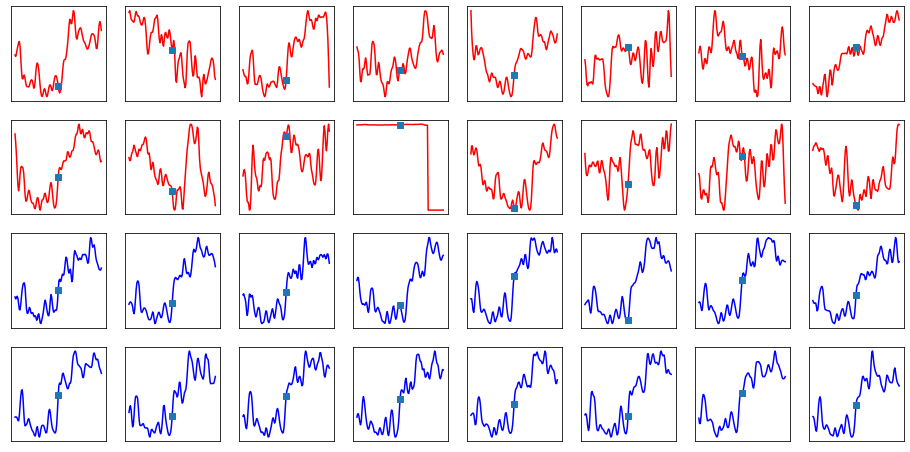

In [148]:
w, h = 2 * n_clusters_ + 2 , 8
sample_num = 16
samples = {label: [well_marker[wn] for wn in random_sample_n(wns, min(sample_num, len(wns)))] for label, wns in clustered_well_names.items()}

fig, axes = plt.subplots(w, h, figsize=(16, 4+4*n_clusters_))
# fig.suptitle(f"Randomly sampled clustered/noise makers with {2*WIN_LEN+1} GR measures with normalization for top {top_}")
# print("Window size =", 2*WIN_LEN+1, ' GR measures' )

for i, ax in enumerate(axes.flat[:min(sample_num, len(clustered_well_names[-1]))]):
    data = samples[-1][i]
    ax.plot(range(len(data)), data, color='r')
    ax.plot([WIN_LEN], [data[WIN_LEN]], 's')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

colors = ['b', 'g', 'c', 'm', 'y', 'k', 'b', 'g']
for k in range(n_clusters_):
    label = [l for l in list(samples.keys()) if l != -1][k]
    wn_nums = len(clustered_well_names[label])
    for i, ax in enumerate(axes.flat[sample_num*(k+1) : sample_num*(k+1) + min(sample_num, wn_nums) ]):
        data = samples[k][i]
        ax.plot(range(len(data)), data, color=colors[k])
        ax.plot([WIN_LEN], [data[WIN_LEN]], 's')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # ax.set_title('Avg w. norm')


plt.show()

In [149]:
df = pd.DataFrame({'wellName': well_names , 'cluster': labels})

In [150]:
df

,wellName,cluster
0,512320698.0,0
1,512320699.0,0
2,512320928.0,0
3,512320970.0,0
4,512320971.0,0
...,...,...
581,512334042.0,-1
582,512334043.0,-1
583,512335135.0,0
584,512335370.0,-1


In [151]:
tops = ['SYLVAIN', 'MARCEL', 'CONRAD']

df_logs_ = pd.read_parquet("../data/logs.parquet")
df_loc_ = pd.read_parquet("../data/loc.parquet")
df_tops_ = pd.read_parquet("../data/tops.parquet")

In [152]:
df_logs_test_ = pd.read_parquet("../testdata/logs_50.parquet")
df_loc_test_ = pd.read_parquet("../testdata/loc_50.parquet")
df_tops_test_ = pd.read_csv("../testdata/tops_50.csv", index_col=0)

In [153]:
merged_df = pd.merge(df_tops_, df, left_on='wellName', right_on='wellName', how='right')

In [154]:
df_tops_ = filtered_df = merged_df[(merged_df['cluster'] == 0)].drop('cluster', axis=1).set_index('wellName')


In [155]:
valid_wells = df_tops_.index.values.tolist()


In [156]:
df_logs_ =  df_logs_[df_logs_['wellName'].isin(valid_wells)]

In [157]:
df_logs_

,wellName,DEPTH,GR
1,512320698.0,421.0,96.9752
2,512320698.0,421.5,102.3324
3,512320698.0,422.0,104.6432
4,512320698.0,422.5,99.2187
5,512320698.0,423.0,92.0200
...,...,...,...
9650828,512336327.0,7187.5,780.6628
9650829,512336327.0,7188.0,798.1260
9650830,512336327.0,7188.5,808.1805
9650831,512336327.0,7189.0,810.6509


In [158]:
train_dataset = generate_top_dataset(df_logs=df_logs_, df_tops=df_tops_, top=top_)
test_dataset = generate_top_dataset(df_logs=df_logs_test_, df_tops=df_tops_test_, top=top_)

In [159]:
print(f'train windows {len(train_dataset[0])}')
print(f'test windows {len(test_dataset[0])}')

X_train = np.array(train_dataset[0]).squeeze(axis=2)
y_train = np.array(train_dataset[1])
X_test = np.array(test_dataset[0]).squeeze(axis=2)
y_test = np.array(test_dataset[1])

train windows 102090
test windows 9978


In [160]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV

In [161]:
SEED = 4556
rfc = RandomForestClassifier(bootstrap=True,n_estimators=500, max_features = 'log2', max_depth=12, criterion = 'gini', random_state=SEED)

In [162]:
# Fit RandomForestClassifier
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, max_features='log2', n_estimators=500,
                       random_state=4556)

In [163]:
tree = rfc.estimators_[0]
from sklearn.tree import export_graphviz
from IPython import display
import os
str_tree = export_graphviz(tree, filled=True, rounded=True, out_file="tree.png")
display.display(str_tree)
# os.system('dot -Tpng tree.dot -o tree.png')

None

In [164]:
# Predict the test set labels
y_pred = rfc.predict(X_test)

In [165]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99      9235
        True       0.87      0.88      0.88       743

    accuracy                           0.98      9978
   macro avg       0.93      0.94      0.93      9978
weighted avg       0.98      0.98      0.98      9978



In [166]:
def evaluate_windows(self, candidate_windows):
    return self.predict_proba(candidate_windows)[:,1]
import types
rfc.evaluate_windows = types.MethodType(evaluate_windows, rfc)

In [167]:
top_finder = TopFinder(rfc, top_)
top_finder.examine_dataset(df_tops_)

In [168]:
test_well_names = df_logs_test_['wellName'].unique()
print(len(test_well_names))

50


In [169]:
from tqdm import tqdm
result = []
for test_well_name in tqdm(test_well_names):
    print(f'well: {test_well_name}')
    df_test_well = df_logs_test_[df_logs_test_['wellName'] == test_well_name]
    predicted_depth = top_finder.find_top(df_test_well)
    true_depth = get_true_depth(test_well_name, top_, df_tops_test_)
    result.append([test_well_name, predicted_depth, true_depth])
    print(f'true depth: {true_depth}\t predicated depth: {predicted_depth}\t error: {abs(predicted_depth - true_depth)}')

  0%|          | 0/50 [00:00<?, ?it/s]

well: 512320936.0


  2%|▏         | 1/50 [00:00<00:42,  1.14it/s]

1973 candidate windows
true depth: 6791.0	 predicated depth: 6790.5	 error: 0.5
well: 512320968.0


  4%|▍         | 2/50 [00:01<00:41,  1.15it/s]

1979 candidate windows
true depth: 6814.0	 predicated depth: 6814.5	 error: 0.5
well: 512320984.0


  6%|▌         | 3/50 [00:02<00:42,  1.11it/s]

1833 candidate windows
true depth: 6740.0	 predicated depth: 6742.0	 error: 2.0
well: 512322242.0


  8%|▊         | 4/50 [00:03<00:39,  1.16it/s]

1561 candidate windows
true depth: 6608.0	 predicated depth: 6606.0	 error: 2.0
well: 512322535.0


 10%|█         | 5/50 [00:04<00:39,  1.13it/s]

2531 candidate windows
true depth: 6620.0	 predicated depth: 6618.0	 error: 2.0
well: 512322732.0


 12%|█▏        | 6/50 [00:05<00:38,  1.14it/s]

2079 candidate windows
true depth: 6851.0	 predicated depth: 6852.5	 error: 1.5
well: 512322775.0


 14%|█▍        | 7/50 [00:06<00:37,  1.15it/s]

1813 candidate windows
true depth: 6743.0	 predicated depth: 6742.5	 error: 0.5
well: 512322788.0


 16%|█▌        | 8/50 [00:07<00:37,  1.13it/s]

1575 candidate windows
true depth: 6637.0	 predicated depth: 6637.5	 error: 0.5
well: 512322802.0


 18%|█▊        | 9/50 [00:07<00:36,  1.12it/s]

1829 candidate windows
true depth: 6746.0	 predicated depth: 6744.5	 error: 1.5
well: 512322973.0


 20%|██        | 10/50 [00:08<00:35,  1.14it/s]

1959 candidate windows
true depth: 6802.0	 predicated depth: 6801.5	 error: 0.5
well: 512323140.0


 22%|██▏       | 11/50 [00:09<00:33,  1.16it/s]

1815 candidate windows
true depth: 6726.0	 predicated depth: 6725.5	 error: 0.5
well: 512323171.0


 24%|██▍       | 12/50 [00:10<00:32,  1.18it/s]

1641 candidate windows
true depth: 6626.0	 predicated depth: 6625.0	 error: 1.0
well: 512323172.0


 26%|██▌       | 13/50 [00:11<00:30,  1.20it/s]

1551 candidate windows
true depth: 6624.0	 predicated depth: 6623.5	 error: 0.5
well: 512323383.0


 28%|██▊       | 14/50 [00:12<00:29,  1.22it/s]

1481 candidate windows
true depth: 6558.0	 predicated depth: 6556.0	 error: 2.0
well: 512323384.0


 30%|███       | 15/50 [00:12<00:28,  1.23it/s]

1545 candidate windows
true depth: 6582.0	 predicated depth: 6582.5	 error: 0.5
well: 512323876.0


 32%|███▏      | 16/50 [00:13<00:28,  1.20it/s]

2269 candidate windows
true depth: 6954.0	 predicated depth: 6952.0	 error: 2.0
well: 512323901.0


 34%|███▍      | 17/50 [00:14<00:27,  1.19it/s]

2253 candidate windows
true depth: 6962.0	 predicated depth: 6960.5	 error: 1.5
well: 512324020.0


 36%|███▌      | 18/50 [00:15<00:27,  1.18it/s]

2125 candidate windows
true depth: 6890.0	 predicated depth: 6890.5	 error: 0.5
well: 512324081.0


 38%|███▊      | 19/50 [00:16<00:26,  1.19it/s]

1855 candidate windows
true depth: 6730.0	 predicated depth: 6730.0	 error: 0.0
well: 512324084.0


 40%|████      | 20/50 [00:17<00:25,  1.18it/s]

1919 candidate windows
true depth: 6805.0	 predicated depth: 6803.5	 error: 1.5
well: 512324444.0


 42%|████▏     | 21/50 [00:17<00:24,  1.18it/s]

1973 candidate windows
true depth: 6837.0	 predicated depth: 6836.0	 error: 1.0
well: 512324766.0


 44%|████▍     | 22/50 [00:18<00:23,  1.19it/s]

1941 candidate windows
true depth: 6848.0	 predicated depth: 6849.0	 error: 1.0
well: 512325048.0


 46%|████▌     | 23/50 [00:19<00:22,  1.18it/s]

1917 candidate windows
true depth: 6798.0	 predicated depth: 6798.0	 error: 0.0
well: 512325052.0


 48%|████▊     | 24/50 [00:20<00:21,  1.19it/s]

1759 candidate windows
true depth: 6753.0	 predicated depth: 6755.0	 error: 2.0
well: 512325116.0


 50%|█████     | 25/50 [00:21<00:20,  1.22it/s]

1445 candidate windows
true depth: 6590.0	 predicated depth: 6590.0	 error: 0.0
well: 512325132.0


 52%|█████▏    | 26/50 [00:22<00:19,  1.21it/s]

1701 candidate windows
true depth: 6660.0	 predicated depth: 6657.0	 error: 3.0
well: 512325600.0


 54%|█████▍    | 27/50 [00:22<00:19,  1.20it/s]

1885 candidate windows
true depth: 6742.0	 predicated depth: 6743.5	 error: 1.5
well: 512325665.0


 56%|█████▌    | 28/50 [00:23<00:18,  1.20it/s]

1901 candidate windows
true depth: 6809.0	 predicated depth: 6808.0	 error: 1.0
well: 512325802.0


 58%|█████▊    | 29/50 [00:24<00:17,  1.21it/s]

1867 candidate windows
true depth: 6789.0	 predicated depth: 6792.5	 error: 3.5
well: 512325817.0


 60%|██████    | 30/50 [00:25<00:16,  1.20it/s]

1937 candidate windows
true depth: 6875.0	 predicated depth: 6875.0	 error: 0.0
well: 512326025.0


 62%|██████▏   | 31/50 [00:26<00:15,  1.21it/s]

1869 candidate windows
true depth: 6804.0	 predicated depth: 6804.5	 error: 0.5
well: 512326044.0


 64%|██████▍   | 32/50 [00:27<00:14,  1.20it/s]

1803 candidate windows
true depth: 6740.0	 predicated depth: 6739.5	 error: 0.5
well: 512326065.0


 66%|██████▌   | 33/50 [00:27<00:13,  1.23it/s]

1371 candidate windows
true depth: 6536.0	 predicated depth: 6529.0	 error: 7.0
well: 512326066.0


 68%|██████▊   | 34/50 [00:28<00:12,  1.27it/s]

1371 candidate windows
true depth: 6567.0	 predicated depth: 6566.0	 error: 1.0
well: 512326072.0


 70%|███████   | 35/50 [00:29<00:12,  1.25it/s]

1969 candidate windows
true depth: 6762.0	 predicated depth: 6763.5	 error: 1.5
well: 512326092.0


 72%|███████▏  | 36/50 [00:30<00:11,  1.24it/s]

1909 candidate windows
true depth: 6834.0	 predicated depth: 6832.5	 error: 1.5
well: 512326146.0


 74%|███████▍  | 37/50 [00:31<00:10,  1.24it/s]

1757 candidate windows
true depth: 6729.0	 predicated depth: 6728.5	 error: 0.5
well: 512326190.0


 76%|███████▌  | 38/50 [00:31<00:09,  1.23it/s]

1877 candidate windows
true depth: 6812.0	 predicated depth: 6809.5	 error: 2.5
well: 512326318.0


 78%|███████▊  | 39/50 [00:32<00:09,  1.22it/s]

1877 candidate windows
true depth: 6779.0	 predicated depth: 6776.5	 error: 2.5
well: 512326383.0


 80%|████████  | 40/50 [00:33<00:08,  1.18it/s]

1897 candidate windows
true depth: 6826.0	 predicated depth: 6825.5	 error: 0.5
well: 512326812.0


 82%|████████▏ | 41/50 [00:34<00:07,  1.20it/s]

1671 candidate windows
true depth: 6739.0	 predicated depth: 6739.5	 error: 0.5
well: 512326906.0


 84%|████████▍ | 42/50 [00:35<00:06,  1.22it/s]

1473 candidate windows
true depth: 6538.0	 predicated depth: 6538.0	 error: 0.0
well: 512327047.0


 86%|████████▌ | 43/50 [00:36<00:05,  1.22it/s]

1719 candidate windows
true depth: 6693.0	 predicated depth: 6694.0	 error: 1.0
well: 512327050.0


 88%|████████▊ | 44/50 [00:36<00:04,  1.23it/s]

1773 candidate windows
true depth: 6738.0	 predicated depth: 6739.5	 error: 1.5
well: 512329241.0


 90%|█████████ | 45/50 [00:37<00:04,  1.23it/s]

1857 candidate windows
true depth: 6868.0	 predicated depth: 6867.5	 error: 0.5
well: 512330173.0


 92%|█████████▏| 46/50 [00:38<00:03,  1.25it/s]

1483 candidate windows
true depth: 6580.0	 predicated depth: 6582.5	 error: 2.5
well: 512330506.0


 94%|█████████▍| 47/50 [00:39<00:02,  1.27it/s]

1321 candidate windows
true depth: 6543.0	 predicated depth: 6541.5	 error: 1.5
well: 512330515.0


 96%|█████████▌| 48/50 [00:39<00:01,  1.28it/s]

1393 candidate windows
true depth: 6528.0	 predicated depth: 6527.5	 error: 0.5
well: 512331401.0


 98%|█████████▊| 49/50 [00:40<00:00,  1.28it/s]

1445 candidate windows
true depth: 6587.0	 predicated depth: 6588.0	 error: 1.0
well: 512331484.0


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]

1263 candidate windows
true depth: 6499.0	 predicated depth: 6500.5	 error: 1.5


In [170]:
df_result = pd.DataFrame(result, columns=['wellName', 'predicated_depth', 'true_depth']).set_index('wellName')
df_tops_pred = df_result[['predicated_depth']].rename(columns={'predicated_depth': top_})
df_tops_true = df_result[['true_depth']].rename(columns={'true_depth': top_})

In [171]:
from hacktops.evaluate import recall_tops

recall, mae, df_res = recall_tops(df_tops_true, df_tops_pred, tolerance = 5)
print("recall {0}, mae {1}".format(recall,mae))

recall 0.98, mae 1.26


In [172]:
df_res.iloc[:,-1:].value_counts()

CONRAD_tp
True         49
False         1
dtype: int64